In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, f1_score, recall_score
from sklearn.metrics import ConfusionMatrixDisplay

try:
    df1 = pd.read_csv("mxmh_survey_results.csv")
    print("Dataset loaded successfully.")
except FileNotFoundError:
    print("Error: The CSV file was not found at the specified path.")
    print("Please ensure 'mxmh_survey_results.csv' is in the correct directory.")
    exit()



Dataset loaded successfully.


In [19]:
df1.columns = df1.columns.str.strip()

print("\nData Information")
df1.info()

print("\nFirst 20 Rows of the Dataset")
print(df1.head(20).to_string())

print("\nRaw 'Music effects' unique values and counts before cleaning")
print(df1['Music effects'].unique())
print(df1['Music effects'].value_counts())



Data Information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    

Exploratory Data Analysis (EDA)


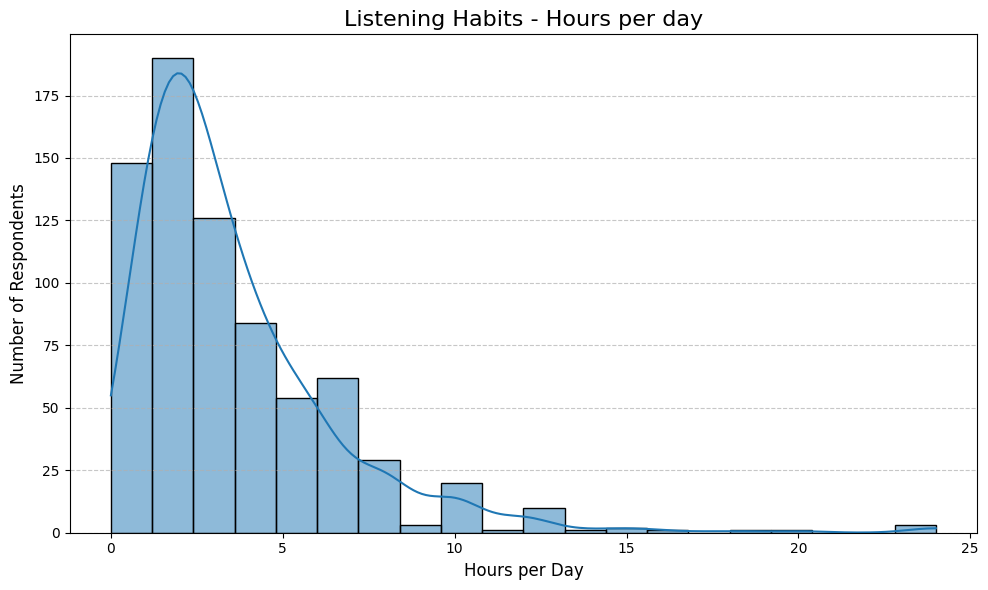

In [31]:
# Histogram for 'Hours per day'
if 'Hours per day' in df1.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df1, x='Hours per day', kde=True, bins=20)
    plt.title('Listening Habits - Hours per day', fontsize=16)
    plt.xlabel('Hours per Day', fontsize=12)
    plt.ylabel('Number of Respondents', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'Hours per day' column not found for EDA.")

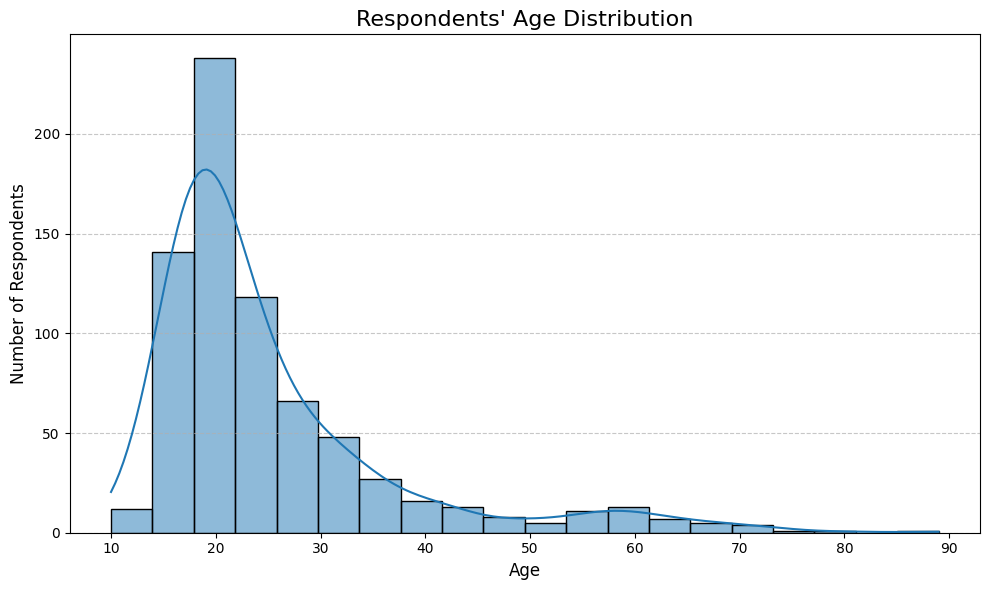

In [22]:
# Histogram for 'Age'
if 'Age' in df1.columns:
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df1, x='Age', kde=True, bins=20)
    plt.title("Respondents' Age Distribution", fontsize=16)
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Number of Respondents', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("'Age' column not found for EDA.")


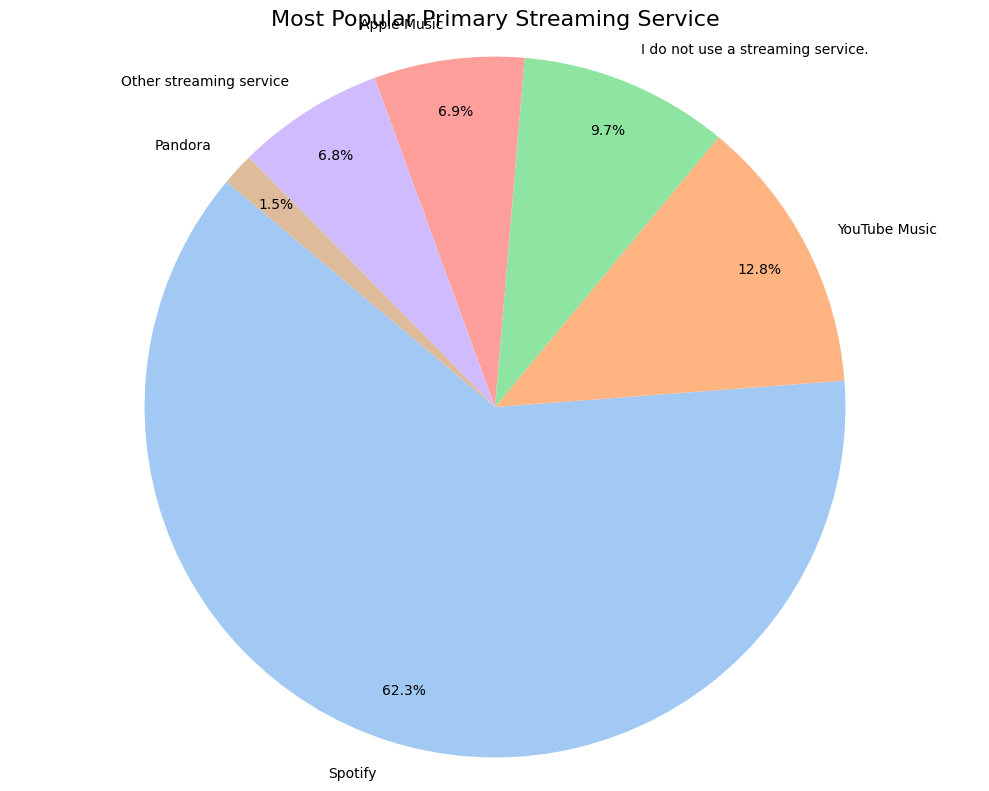

In [23]:

# Pie chart for 'Primary streaming service'
df_streaming_servies = df1['Primary streaming service'].value_counts().reset_index()
palette_color = sns.color_palette('pastel')[0:len(df_streaming_servies)]

plt.figure(figsize=(10, 8))
plt.pie(df_streaming_servies['count'], labels=df_streaming_servies['Primary streaming service'],
        colors=palette_color, autopct='%.1f%%', startangle=140, pctdistance=0.85)
plt.title('Most Popular Primary Streaming Service', fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()


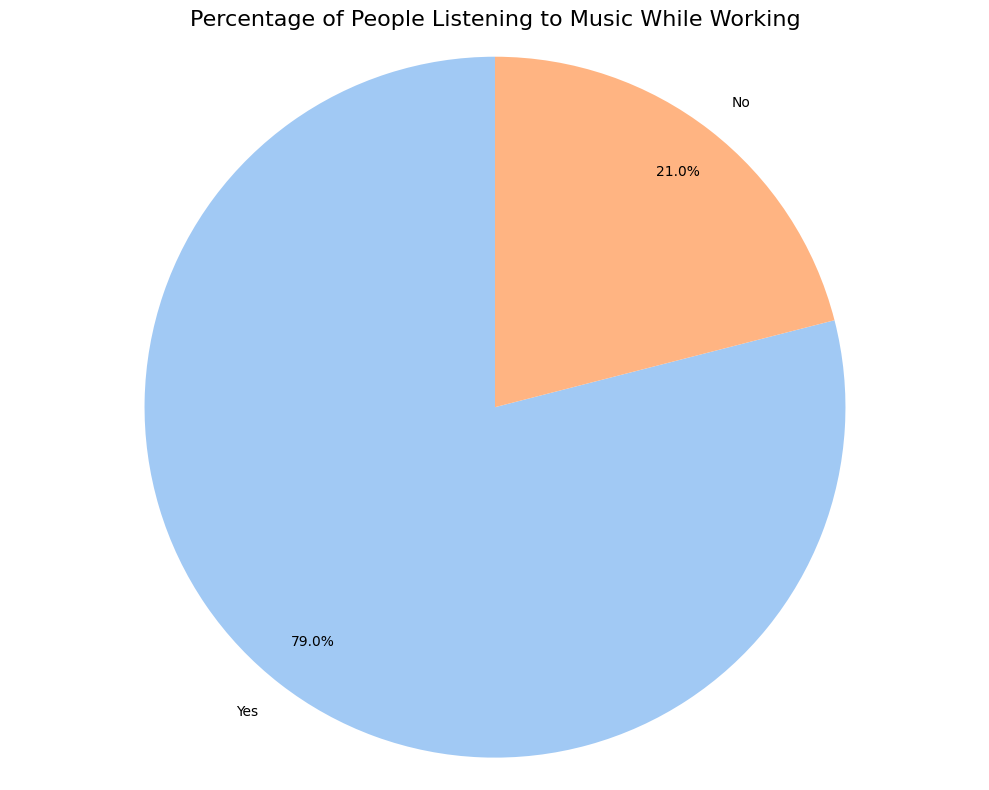

In [24]:

# Pie chart for 'While working'
df_while_working = df1['While working'].value_counts().reset_index()
plt.figure(figsize=(10, 8))
plt.pie(df_while_working['count'], labels=df_while_working['While working'],
        colors=palette_color, autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.title("Percentage of People Listening to Music While Working", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()



/tmp/ipython-input-748901935.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  music_effect_for_plotting = music_effect_for_plotting.replace(['No effect', 'Worsen'], 0.0)


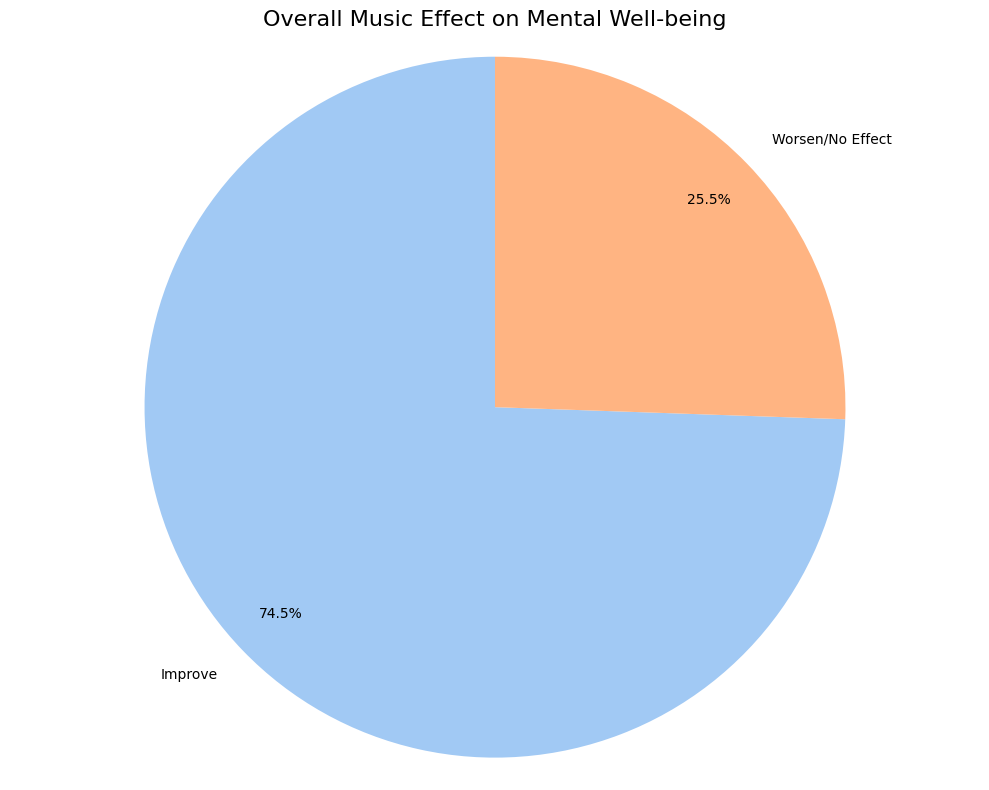

In [25]:
# Pie chart for 'Music effects'
music_effect_for_plotting = df1['Music effects'].copy()
# Map specific string values to numeric for plotting labels
music_effect_for_plotting = music_effect_for_plotting.replace('Improve', 1.0)
music_effect_for_plotting = music_effect_for_plotting.replace(['No effect', 'Worsen'], 0.0)
music_effect_for_plotting = pd.to_numeric(music_effect_for_plotting, errors='coerce')
music_effect_for_plotting = music_effect_for_plotting.replace({1.0: 'Improve', 0.0: 'Worsen/No Effect'})
music_effect_for_plotting = music_effect_for_plotting.dropna()

df_music_effect = music_effect_for_plotting.value_counts().reset_index()
plt.figure(figsize=(10, 8))
plt.pie(df_music_effect['count'], labels=df_music_effect['Music effects'],
        colors=palette_color, autopct='%.1f%%', startangle=90, pctdistance=0.85)
plt.title("Overall Music Effect on Mental Well-being", fontsize=16)
plt.axis('equal')
plt.tight_layout()
plt.show()


Prepare Data for Classification Model


In [32]:

df1['Music effects'] = df1['Music effects'].replace('Improve', 1.0)

df1['Music effects'] = df1['Music effects'].replace(['No effect', 'Worsen'], 0.0)

df1['Music effects'] = pd.to_numeric(df1['Music effects'], errors='coerce')

df_cleaned = df1.dropna(subset=['Music effects']).copy()

y = df_cleaned['Music effects']
one_hot_encoded_genres_columns = df_cleaned.filter(like='Fav genre_').columns
X = df_cleaned[[ 'Anxiety', 'Depression', 'Insomnia', 'OCD'] + list(one_hot_encoded_genres_columns)]

print("\n'Music effects' value counts after cleaning for modeling")
print(y.value_counts())

if X.empty or y.empty:
    print(f"Error: X (shape {X.shape}) or y (shape {y.shape}) are empty after handling missing 'Music effects' values.")
    print("This means all rows were likely dropped. Please check the 'Music effects' column in your CSV for unexpected values.")
    exit()

if y.nunique() < 2:
    print(f"Error: The target variable 'Music effects' contains only one unique class ({y.unique()}) after cleaning.")
    print("Cannot perform classification with only one class. Please check your data and cleaning steps.")
    exit()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


Preparing Data for Classification Model

'Music effects' value counts after cleaning for modeling
Music effects
1.0    542
0.0    186
Name: count, dtype: int64
X_train shape: (582, 4), y_train shape: (582,)
X_test shape: (146, 4), y_test shape: (146,)


Training and Evaluating Classifiers



Training Logistic Regression...
Confusion matrix for Logistic Regression:
[[  0  37]
 [  0 109]]
Logistic Regression Accuracy: 74.66%
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        37
         1.0       0.75      1.00      0.85       109

    accuracy                           0.75       146
   macro avg       0.37      0.50      0.43       146
weighted avg       0.56      0.75      0.64       146



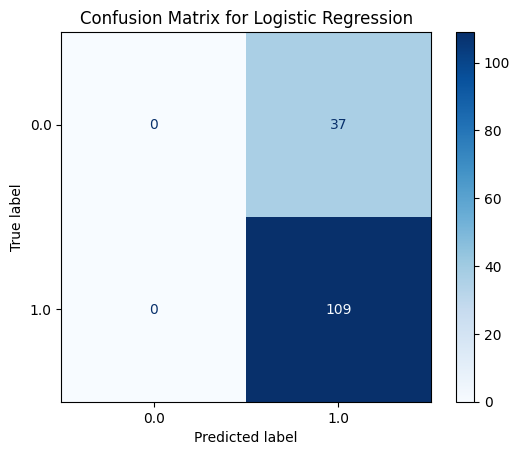


Training Decision Tree...
Confusion matrix for Decision Tree:
[[17 20]
 [23 86]]
Decision Tree Accuracy: 70.55%
              precision    recall  f1-score   support

         0.0       0.42      0.46      0.44        37
         1.0       0.81      0.79      0.80       109

    accuracy                           0.71       146
   macro avg       0.62      0.62      0.62       146
weighted avg       0.71      0.71      0.71       146



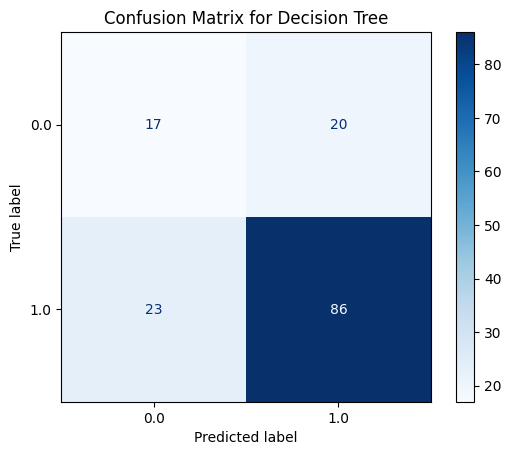


Training Random Forest...
Confusion matrix for Random Forest:
[[ 9 28]
 [15 94]]
Random Forest Accuracy: 70.55%
              precision    recall  f1-score   support

         0.0       0.38      0.24      0.30        37
         1.0       0.77      0.86      0.81       109

    accuracy                           0.71       146
   macro avg       0.57      0.55      0.55       146
weighted avg       0.67      0.71      0.68       146



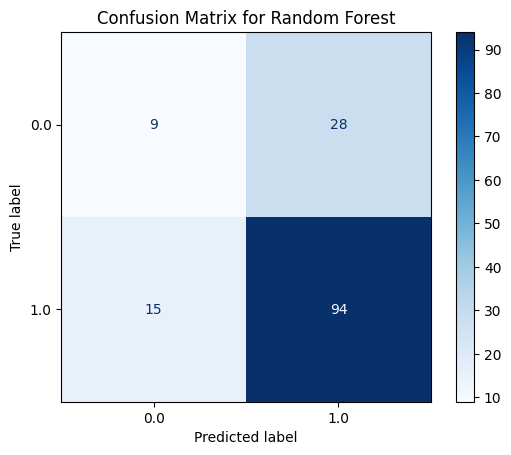

In [33]:
results = {}
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000, solver='liblinear'),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    try:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        print(f"Confusion matrix for {name}:\n{cm}")

        accuracy = accuracy_score(y_test, y_pred)
        results[name] = accuracy
        print(f"{name} Accuracy: {accuracy*100:.2f}%")

        report = classification_report(y_test, y_pred, zero_division=0)
        print(report)

        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        disp.plot(cmap='Blues')
        plt.title(f'Confusion Matrix for {name}')
        plt.show()

    except Exception as e:
        print(f"Error training/evaluating {name}: {e}")


Optimized Decision Tree Model


Best Hyperparameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Optimized Decision Tree Test Accuracy: 76.03%
Classification Report for Optimized Decision Tree:
              precision    recall  f1-score   support

         0.0       0.60      0.16      0.26        37
         1.0       0.77      0.96      0.86       109

    accuracy                           0.76       146
   macro avg       0.69      0.56      0.56       146
weighted avg       0.73      0.76      0.70       146

Confusion Matrix for Optimized Decision Tree:
[[  6  31]
 [  4 105]]


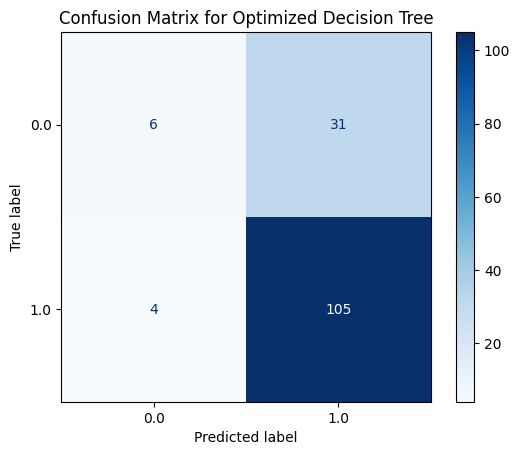

Decision Tree Cross-Validation Scores: [0.75213675 0.76068376 0.71551724 0.77586207 0.76724138]
Average Decision Tree Cross-Validation Score: 0.7543
Optimized Decision Tree Precision (weighted): 0.7285%
Optimized Decision Tree F1-Score (weighted): 0.7046%


In [34]:

dt_model = DecisionTreeClassifier(random_state=42)
param_grid_dt = {
    'max_depth': [3, 5, 10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

grid_search_dt = GridSearchCV(estimator=dt_model, param_grid=param_grid_dt, cv=5, n_jobs=-1, scoring='accuracy')
grid_search_dt.fit(X_train, y_train)

best_dt_model = grid_search_dt.best_estimator_
print(f"Best Hyperparameters for Decision Tree: {grid_search_dt.best_params_}")

y_pred_dt_optimized = best_dt_model.predict(X_test)
test_accuracy_dt = accuracy_score(y_test, y_pred_dt_optimized)
print(f"Optimized Decision Tree Test Accuracy: {test_accuracy_dt*100:.2f}%")

print(f"Classification Report for Optimized Decision Tree:\n{classification_report(y_test, y_pred_dt_optimized, zero_division=0)}")
cm_dt_optimized = confusion_matrix(y_test, y_pred_dt_optimized)
print(f"Confusion Matrix for Optimized Decision Tree:\n{cm_dt_optimized}")

disp_dt_opt = ConfusionMatrixDisplay(confusion_matrix=cm_dt_optimized, display_labels=best_dt_model.classes_)
disp_dt_opt.plot(cmap='Blues')
plt.title(f'Confusion Matrix for Optimized Decision Tree')
plt.show()


cv_scores_dt = cross_val_score(best_dt_model, X_train, y_train, cv=5)
print(f"Decision Tree Cross-Validation Scores: {cv_scores_dt}")
print(f"Average Decision Tree Cross-Validation Score: {cv_scores_dt.mean():.4f}")

precision_dt = precision_score(y_test, y_pred_dt_optimized, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt_optimized, average='weighted', zero_division=0)
print(f"Optimized Decision Tree Precision (weighted): {precision_dt:.4f}%")
print(f"Optimized Decision Tree F1-Score (weighted): {f1_dt:.4f}%")
